In [1]:
from datasetcontroller.datacontroller import DataController
import tensorflow as tf
from nnmodules.unet import Unet_v2_1
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import numpy as np

2023-06-28 15:04:22.243539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 15:04:22.367007: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
BATCH_SIZE = 4
train_set_len = 100
shuffle_buffer_size = 100


def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(8, 8))
  # display_list = [test_input[0][0][:,:,:3], tar[0][:,:,0][::-1], prediction[0][::-1]]
  # title = ['Input', 'Ground Truth', 'Predicted Image']
  print(prediction.shape, tar.shape)
  display_list = [tar[0][::-1], prediction[0][::-1]]
  title = ['Ground Truth', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

* 데이터셋 정리

In [3]:
# set dataset path
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# get controller
datacontroller = DataController(data_path = data_path)

# control matrix, smoke, cmaq 
control_matrix, smoke_arr, target_arr = datacontroller.get_yearly_dataset()

# 학습용셋
train_input = smoke_arr[:train_set_len]
test_input = smoke_arr[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')
2023-06-28 15:04:29.540161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22201 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-06-28 15:04:29.540791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

* 모델

In [4]:
optimizer = tf.keras.optimizers.Adam(0.001)
unet = Unet_v2_1()
unet.compile()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 unet=unet,
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)


1


2023-06-28 15:04:30.523051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


(1, 82, 67, 1) (1, 82, 67, 1)


2023-06-28 15:04:32.085680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


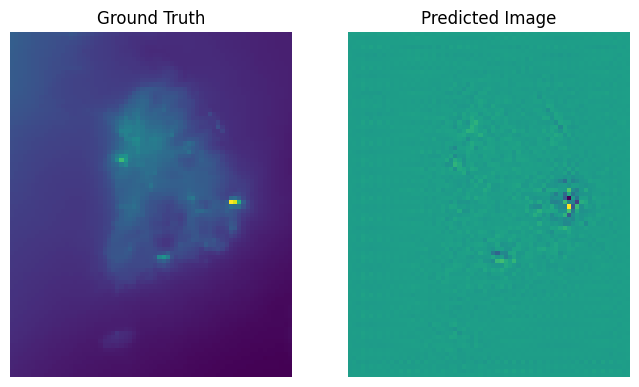

In [5]:

for batch in test_ds.take(1):
    print(1)
generate_images(unet, batch[0][0:1], batch[1][0:1])

* 학습

In [6]:
import datetime

init_lr = 0.0001
steps = 3000

In [7]:
@tf.function
def train_step(input, target,optimizer):
    with tf.GradientTape() as tape:
        output = unet(input, training=True)
        l1_loss = unet.lose_mse(target, output)
    gradients = tape.gradient(l1_loss,
                                            unet.trainable_variables)

    optimizer.apply_gradients(zip(gradients,
                                            unet.trainable_variables))
start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()
    print(f"Step: {step}")

  train_step(input_arr, target,optimizer)

  if step % 1000 == 0:
    if step != 0:
      init_lr = init_lr*0.1
      optimizer = tf.keras.optimizers.Adam(init_lr)
      @tf.function
      def train_step(input_image, target,optimizer):
          with tf.GradientTape() as tape:
              output = unet(input_image, training=True)
              l1_loss = unet.lose_mse(target, output)
          gradients = tape.gradient(l1_loss,
                                                  unet.trainable_variables)

          optimizer.apply_gradients(zip(gradients,
                                                  unet.trainable_variables))

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # # Save (checkpoint) the model every 5k steps
  # if (step + 1) % 1000 == 0:
  #   checkpoint.save(file_prefix=checkpoint_prefix)

Step: 0
..........Time taken for 100 steps: 9.08 sec

Step: 100
..........Time taken for 100 steps: 3.02 sec

Step: 200
..........Time taken for 100 steps: 3.09 sec

Step: 300
..........Time taken for 100 steps: 3.11 sec

Step: 400
..........Time taken for 100 steps: 3.12 sec

Step: 500
..........Time taken for 100 steps: 3.08 sec

Step: 600
..........Time taken for 100 steps: 3.12 sec

Step: 700
..........Time taken for 100 steps: 3.02 sec

Step: 800
..........Time taken for 100 steps: 3.09 sec

Step: 900
..........Time taken for 100 steps: 3.02 sec

Step: 1000
..........Time taken for 100 steps: 7.58 sec

Step: 1100
..........Time taken for 100 steps: 3.07 sec

Step: 1200
..........Time taken for 100 steps: 3.05 sec

Step: 1300
..........Time taken for 100 steps: 3.02 sec

Step: 1400
..........Time taken for 100 steps: 3.05 sec

Step: 1500
..........Time taken for 100 steps: 3.06 sec

Step: 1600
..........Time taken for 100 steps: 3.05 sec

Step: 1700
..........Time taken for 100 ste

* 평가

In [8]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, LineString, Point
from geocube.api.core import make_geocube

class KoreaGPD(object):
    city_dict = {
        0: '강원도',
        1: '경기도',
        2: '경상남도',
        3: '경상북도',
        4: '광주광역시',
        5: '대구광역시',
        6: '대전광역시',
        7: '부산광역시',
        8: '서울특별시',
        9: '세종특별자치시',
        10: '울산광역시',
        11: '인천광역시',
        12: '전라남도',
        13: '전라북도',
        14: '제주특별자치도',
        15: '충청남도',
        16: '충청북도'
    }
    proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
    crs = {'init':'epsg:5179'}
    x_m = list(range(-180000,-180000 + 9000 * 67, 9000))
    y_m = list(range(-585000,-585000 + 9000 * 82, 9000))
    n_pixel = 82*67

    def __init__(self):
        self.ctp_rvn_gpd = \
            gpd.GeoDataFrame.from_file(os.path.join(data_path,"geoinfodata","시도","ctp_rvn.shp"),encoding = 'cp949')
        self.ctp_rvn_gpd.crs = self.crs
        grid_data, out_grid = self.make_base_raster()
        joined = gpd.sjoin(self.ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')
        self.idx_grid = pd.merge(
            grid_data, 
            joined.loc[:,['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right']], 
            how='left', 
            left_on='index',
            right_on='index_right'
        )
        self.idx_grid = gpd.GeoDataFrame(self.idx_grid, geometry='geometry')
        self.idx_grid = self.idx_grid.dropna()

    def __call__(self, idx:int=0):
        """Get grid index of each city
        
        City name index
        ---------------
            - 0: 강원도
            - 1: 경기도
            - 2: 경상남도
            - 3: 경상북도
            - 4: 광주광역시
            - 5: 대구광역시
            - 6: 대전광역시
            - 7: 부산광역시
            - 8: 서울특별시
            - 9: 세종특별자치시
            - 10: 울산광역시
            - 11: 인천광역시
            - 12: 전라남도
            - 13: 전라북도
            - 14: 제주특별자치도
            - 15: 충청남도
            - 16: 충청북도
        """
        pix_index = self.idx_grid.loc[self.idx_grid.CTP_KOR_NM==self.city_dict[idx]]
        pix_index = pix_index.index.tolist()
        pix_index = [(idx%82, idx//82) for idx in pix_index]
        return pix_index

    def make_base_raster(self):
        grid_points = []
        for x_i in self.x_m:
            for y_i in self.y_m:
                grid_points.append(Point(x_i, y_i))

        grid_data = pd.DataFrame(grid_points, columns=['geometry'])

        grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
        grid_data.crs = self.ctp_rvn_gpd.to_crs(self.proj).crs
        grid_data.loc[:,'x_m'] = grid_data.geometry.x
        grid_data.loc[:,'y_m'] = grid_data.geometry.y
        grid_data.loc[:,'value'] = 0
        grid_data.loc[:,'index'] = grid_data.index

        out_grid = make_geocube(
            vector_data=grid_data, 
            measurements=["value"],
            resolution=(9000, 9000), 
            fill=0, 
            output_crs=self.proj)
        return grid_data, out_grid
    
    def show_base_map(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        self.idx_grid.to_crs(5179).plot(ax=ax, markersize = 0.1)
        self.ctp_rvn_gpd.plot(ax=ax)
        return fig
    
geodata = KoreaGPD()

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_427548/1469658179.py:37: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(self.ctp_rvn_gpd, grid_data.to_crs(5179), op='co

In [9]:
pred_train = unet.predict(train_input, batch_size = 8)
pred_test = unet.predict(test_input, batch_size = 8)

mask = np.zeros((1, 82, 67, 1))
for i in range(17):
    for x, y in geodata(i):
        mask[0, x, y, 0] = 1

pred_train *= mask
pred_test *= mask

masked_train_output = train_output * mask
masked_test_output = test_output * mask

3/3 [==============================] - 0s 24ms/step


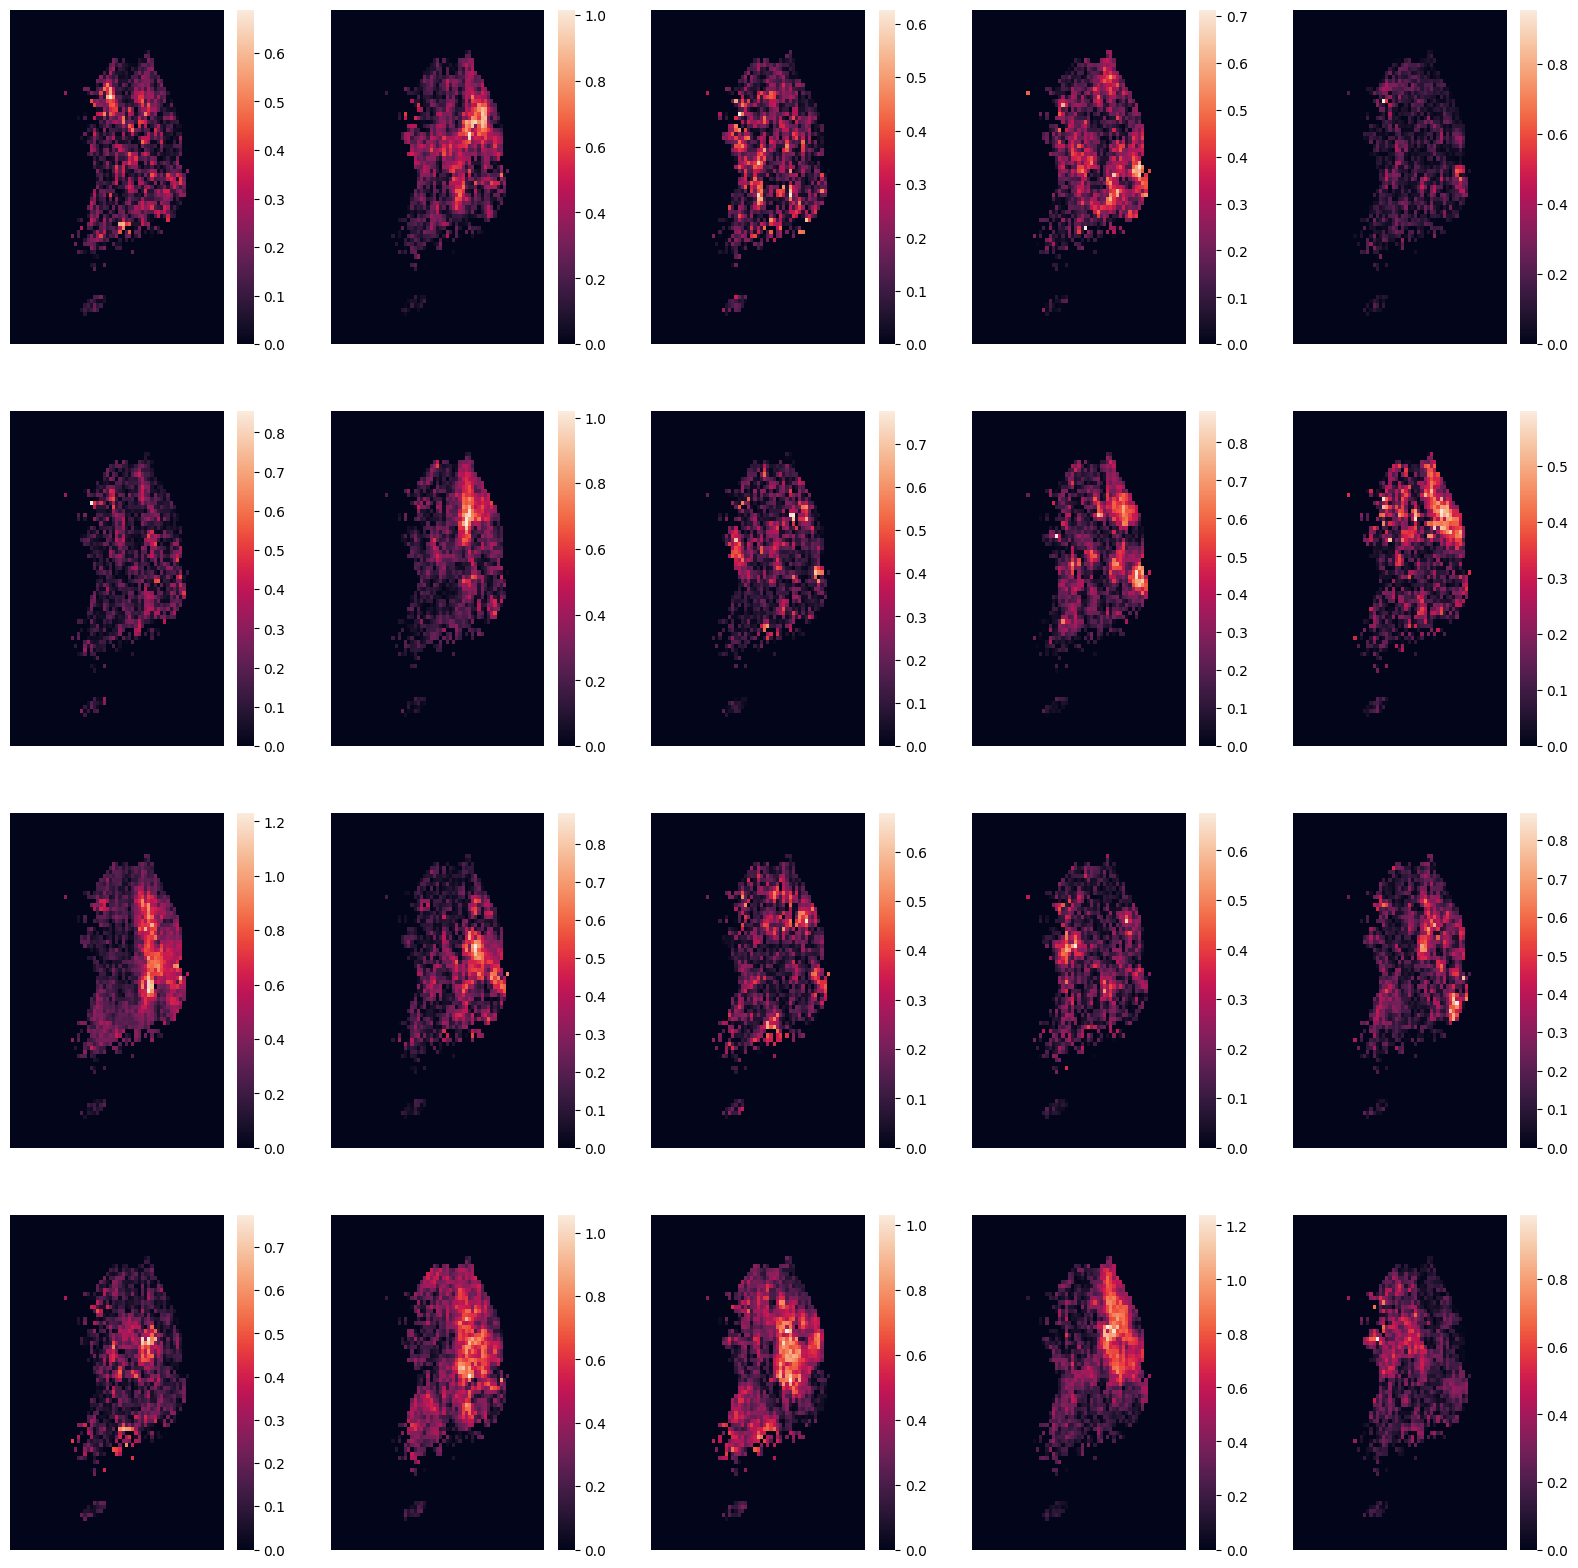

In [10]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for i in range(4):
    for j in range(5):
        idx = 5*i+j
        sns.heatmap(np.abs(pred_test[idx][:,:,0][::-1] - masked_test_output[idx][:,:,0][::-1]), ax=axes[i,j])
        axes[i,j].axis('off')
plt.show()

For train set, Max R2: 0.99996 | Min R2: 0.99970 | Avg. R2: 0.99987 ± 0.00006
For test set, Max R2: 0.99988 | Min R2: 0.99925 | Avg. R2: 0.99969 ± 0.00020


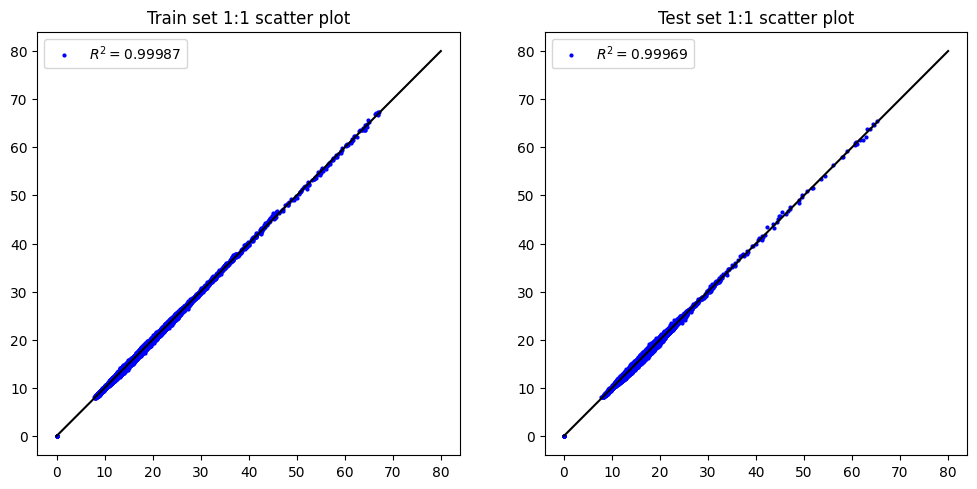

In [11]:
def r_square(y_true, y_pred):
    SS_res = np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_pred)))
    return (1-SS_res / SS_tot)

r_2_train = []
r_2_test = []

for i in range(len(test_input)):
    r_2_train.append(r_square(pred_train[i][::-1].reshape(-1), masked_train_output[i][::-1].reshape(-1)))
    r_2_test.append(r_square(pred_test[i][::-1].reshape(-1), masked_test_output[i][::-1].reshape(-1)))

print("For train set, Max R2: {max_r2:1.5f} | Min R2: {min_r2:1.5f} | Avg. R2: {mean_r2:1.5f} ± {std_r2:1.5f}".\
      format(max_r2=np.max(r_2_train), min_r2=np.min(r_2_train), mean_r2=np.mean(r_2_train), std_r2=np.std(r_2_train)))
print("For test set, Max R2: {max_r2:1.5f} | Min R2: {min_r2:1.5f} | Avg. R2: {mean_r2:1.5f} ± {std_r2:1.5f}".\
      format(max_r2=np.max(r_2_test), min_r2=np.min(r_2_test), mean_r2=np.mean(r_2_test), std_r2=np.std(r_2_test)))

plt.figure(figsize=[12,5.5])

plt.subplot(1,2,1)
plt.title('Train set 1:1 scatter plot')
plt.plot(pred_train.reshape(-1), masked_train_output.reshape(-1), 'bo', markersize=2, label=f'$R^2=${np.mean(r_2_train):.5f}')
plt.plot([0,80], [0,80], color='black')
plt.legend()

plt.subplot(1,2,2)
plt.title('Test set 1:1 scatter plot')
plt.plot(pred_test.reshape(-1), masked_test_output.reshape(-1), 'bo', markersize=2, label=f'$R^2=${np.mean(r_2_test):.5f}')
plt.plot([0,80], [0,80], color='black')
plt.legend()

plt.show()

Max NME: 2.10946 % | Min NME: 0.78617 % | Avg. NME: 1.27984 ± 0.44950 %


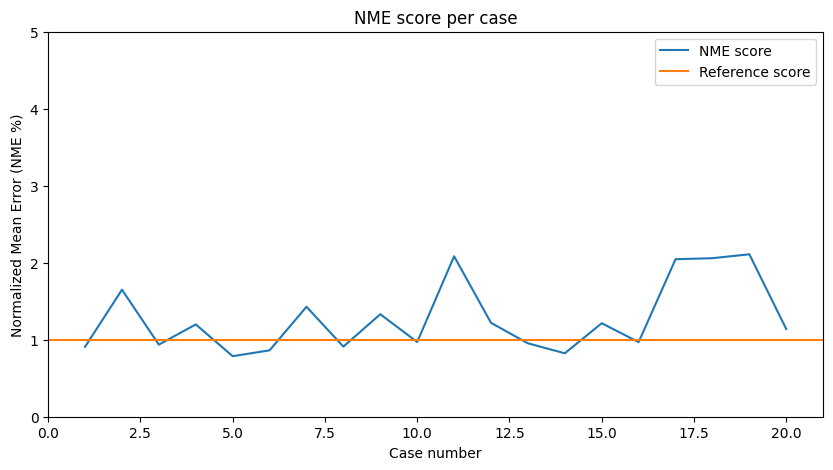

In [12]:
def NME(y_true, y_pred):
    return np.sum(abs((y_pred - y_true)/y_true))/len(y_pred)

result = []

pred_value = []
test_value = []
for batch in range(20):
    tmp_p = []
    tmp_t = []
    for i in range(17):
        tmp_p.extend([pred_test[batch, x, y, 0] for x, y in geodata(i)])
        tmp_t.extend([masked_test_output[batch, x, y, 0] for x, y in geodata(i)])
    pred_value.append(tmp_p)
    test_value.append(tmp_t)
pred_value = np.array(pred_value)
test_value = np.array(test_value)

for i in range(len(test_input)):
    result.append(NME(pred_value[i], test_value[i]))
    
# In[]
plt.figure(figsize=(10,5))
plt.title("NME score per case")
plt.plot(np.arange(1,len(test_input)+1,1), np.array(result) * 100, label='NME score')
plt.xlim([0,len(test_input)+1])
plt.ylim([0,5])
plt.plot([0,len(test_input)+1], [1,1], label='Reference score')
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')
plt.legend()

# In[]
print("Max NME: {max_nme:1.5f} % | Min NME: {min_nme:1.5f} % | Avg. NME: {mean_nme:1.5f} ± {std_nme:1.5f} %".\
      format(max_nme=np.max(result)*100, min_nme=np.min(result)*100, mean_nme=np.mean(result)*100, std_nme=np.std(result)*100))

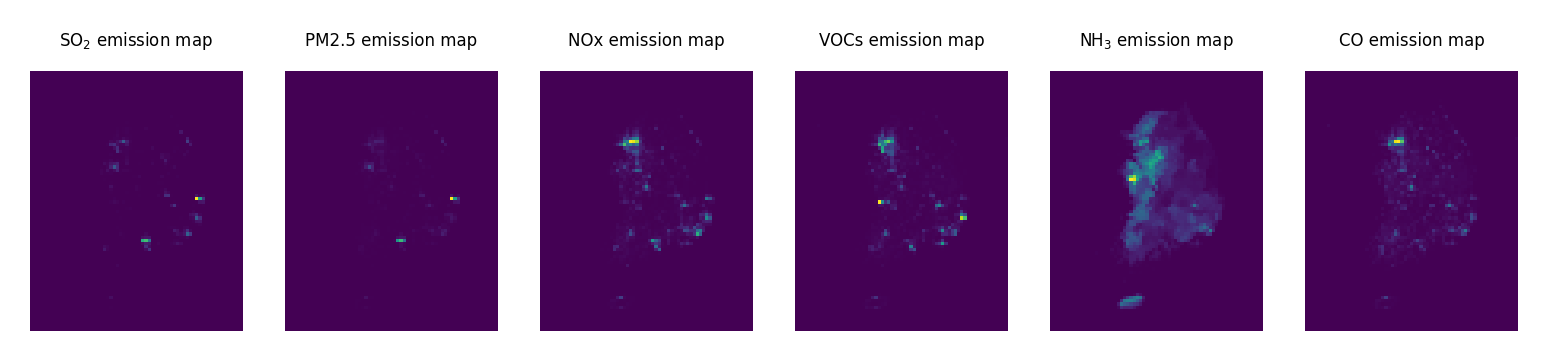

In [25]:
emis_key_list = [r'SO$_2$', 'PM2.5', 'NOx', 'VOCs', 'NH$_3$', 'CO']

fig, ax = plt.subplots(1, 6, dpi=300)
for i in range(6):
    ax[i].imshow(test_input[0, :, :, i][::-1])
    ax[i].set_title(emis_key_list[i]+" emission map", fontsize=4)
    ax[i].axis('off')
plt.show()